In [22]:
%matplotlib notebook
import numpy as np
import networkx as nx
import pandas as pd
import random
from matplotlib import pyplot as plt, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm
from joblib import Parallel, delayed
from copy import copy

from synthetic_data import load_data_by_gtype
from ic import simulated_infection_time_3d, make_partial_cascade
from graph_generator import add_p_and_delta


In [13]:
gtype = 'barabasi'
param = '2-6'
N1 = 100  # experiment round
N2 = 100  # simulation rounds
p = 0.7
q = 0.01
g = load_data_by_gtype(gtype, param)[0]
print('|V|={}'.format(g.number_of_nodes()))

|V|=64


In [14]:
def source_likelihood_given_single_obs(g, o, t, N):
    matching_count = np.zeros(g.number_of_nodes(), dtype=np.float64)
    for i in range(N):
        sg = sample_graph_from_infection(g)
        sp_len = nx.shortest_path_length(sg, source=o)
        times = np.array([sp_len.get(n, float('inf')) for n in np.arange(g.number_of_nodes())])
        matching_count += (times == t)
    return matching_count / N


In [26]:
def source_likelihood_ratios_and_dists_by_obs_pairs(g, p, q, N1, N2, inf_time_3d, f_ref_nodes=0.1, 
                                                    debug=True):
    """inf_time_3d: shape = source x node x rounds"""
    g = add_p_and_delta(g, p, 1)
    source_likelihood_array = []
    sources = []
    dist_array = []
    def extract_proba(s, o1, t1, o2, t2):        
        t1_arr = inf_time_3d[s, o1, :]
        t2_arr = inf_time_3d[s, o2, :]
        return np.sum((t1_arr - t2_arr) == (t1 - t2)) / N2
        
    if debug:
        iters = tqdm(range(N1))
    else:
        iters = range(N1)
    for i in iters:
        source, obs_nodes, infection_times, _ = make_partial_cascade(g, q, 'uniform')
        sources.append(source)
        source_likelihood = np.ones(g.number_of_nodes(), dtype=np.float64)
        
        n_ref_nodes = (int(len(obs_nodes) * f_ref_nodes) or 1)
        ref_nodes = np.random.permutation(np.array(list(obs_nodes)))[:n_ref_nodes]
        remaining_nodes = copy(obs_nodes)
        for ref_node in ref_nodes:
            remaining_nodes -= {ref_node}
            for o in remaining_nodes:
                source_likelihood *= np.array([extract_proba(s,
                                                             o, infection_times[o],
                                                             ref_node, infection_times[ref_node])
                                               for s in np.arange(g.number_of_nodes())])
                source_likelihood /= source_likelihood.sum()
            # source_likelihood_given_single_obs(g, o, infection_times[o], N2)
        max_n = np.argmax(source_likelihood)
        dist_to_max_n = nx.shortest_path_length(g, source=source, target=max_n)
        dist_array.append(dist_to_max_n)
        source_likelihood_array.append(source_likelihood)
    source_likelihood_array = np.array(source_likelihood_array, dtype=np.float64)
    source_llh = np.array([source_likelihood_array[i, src]
                           for i, src in enumerate(sources)])
    ratios = source_llh / source_likelihood_array.max(axis=1)
    return {
        'ratio': pd.Series(ratios[np.invert(np.isnan(ratios))]).describe(),
        'dist': pd.Series(dist_array).describe()
    }

In [28]:
ps = np.linspace(0.1, 1.0, 10)
qs = np.linspace(0.1, 1.0, 10)
ref_nodes_fractions = np.linspace(0.1, 0.5, 5)

In [17]:
inf_time_3d_by_p = {p: simulated_infection_time_3d(add_p_and_delta(g, p, 1), N2) for p in ps}


100%|██████████| 100/100 [00:00<00:00, 567.22it/s]

In [24]:
rows = Parallel(n_jobs=-1)(delayed(source_likelihood_ratios_and_dists_by_obs_pairs)(g, p, q, N1, N2, inf_time_3d_by_p[p],
                                                                                    f_ref_nodes=f_ref_nodes,
                                                                                    debug=False)
                           for p in tqdm(ps) for q in qs for f_ref_nodes in ref_nodes_fractions)




  0%|          | 0/10 [00:00<?, ?it/s]









 10%|█         | 1/10 [00:00<00:01,  5.67it/s]/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered i

<IPython.core.display.Javascript object>


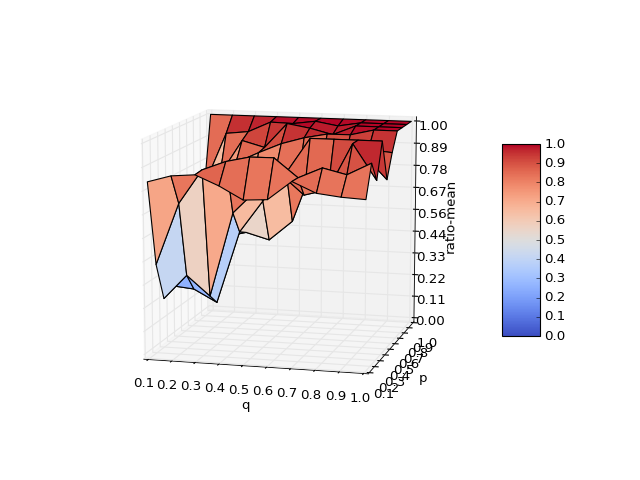

In [25]:
# mpld3.enable_notebook()
fig = plt.figure()
X, Y = np.meshgrid(ps, qs)
ratio_median = np.array([r['ratio']['50%'] for r in rows]).reshape((len(ps), len(qs)))
ratio_mean = np.array([r['ratio']['mean'] for r in rows]).reshape((len(ps), len(qs)))
dist_median = np.array([r['dist']['50%'] for r in rows]).reshape((len(ps), len(qs)))
dist_mean = np.array([r['dist']['mean'] for r in rows]).reshape((len(ps), len(qs)))
to_draw_data = {
    'ratio-median': ratio_median,
    'ratio-mean': ratio_mean,
    'dist-median': dist_median,
    'dist-mean': dist_mean,
}

Z = ratio_mean
name = 'ratio-mean'
plt.clf()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, 
                       rstride=1, cstride=1,
                       vmin=0, vmax=1,
                       cmap=cm.coolwarm)
ax.set_zlim(0, Z.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)    

ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_zlabel(name)
plt.show()


In [ ]:
np.savez('figs/{}/source-likelihood-vs-p-and-q-data'.format(gtype), [X, Y, ratio_median, ratio_mean, dist_median, dist_mean])